In [1]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from  IPython.display import  clear_output

Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 96940.25it/s]


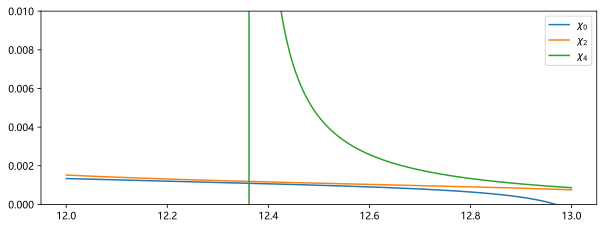

In [2]:
n_evals = 20
qls = [0,2,4]
max_ol = 50
max_ql = 40

fig,ax1 = plt.subplots(figsize=(10, 3.5)) 

EJ_over_EC = 2.7
EJ_over_EL = 45
qbt1 = scqubits.Fluxonium(EJ = 4,EC = 4/EJ_over_EC,EL = 4/EJ_over_EL, cutoff = 110,flux = 0,truncated_dim=n_evals)
evals1 = qbt1.eigenvals(n_evals)
matrix1 =  qbt1.matrixelement_table(operator = "n_operator",evals_count=n_evals)
Er_list1 = np.linspace(12,13,int(1e4))
Er_list1_with_2pi = Er_list1*2*np.pi
ylim  = (-0.01,0.01)
for ql  in qls:
    shift_from_qubit_transition = []
    for Er in tqdm(Er_list1, desc = "Er loop"):
        shifts = [get_shift_accurate(matrix1[ql,ql2], evals1[ql2], evals1[ql], Er) for ql2 in range(n_evals)] 
        shift_from_qubit_transition.append(sum(shifts)/100)
    ax1.plot(Er_list1,2*np.pi* np.array(shift_from_qubit_transition), label=rf'$\chi_{ql}$')

ax1.set_ylim(-0.0,0.01)
ax1.legend()


#  $\Chi_0$ and  $\Chi_2$ don't crossover, but they are close, this means I can match the Rabi oscillation period of a coupled transmon

In [3]:
max_tl = 4

EJ_over_EC = 2.7
EJ_over_EL = 45
fluxonium = scqubits.Fluxonium(EJ = 4,EC = 4/EJ_over_EC,EL = 4/EJ_over_EL, cutoff = 110,flux = 0,truncated_dim=max_ql)


In [4]:
 

# x =   [41.50716548,  0.1961139  ,  0.08726255]
x =[41.4797963 ,  0.24302018 , 0.11446142]


Ej_transmon = x[0]
g = x[1]
amp = x[2] / (2 * np.pi)


transmon = scqubits.Transmon(
    EJ= Ej_transmon,#41.74,
    EC=0.5,
    ng=0.0,
    ncut=10,
    truncated_dim = max_tl
    )
system = FluxoniumTransmonSystem(
    fluxonium  = fluxonium,
    transmon = transmon,
    computaional_states = '0,2',
    g_strength = g,
    )
driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

# tot_time = np.pi/amp / driven_op[system.product_to_dressed[(4,1)],system.product_to_dressed[(4,0)]]
tlist = np.linspace(0,40,1000)

e_ops = []
for ql in range(max_ql):
    for tl in range(max_tl):
        e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))


# first, square pulse

 Total run time:   0.82s*] Elapsed 0.82s / Remaining 00:00:00:00 [*********98%***********] Elapsed 0.81s / Remaining 00:00:00:00
 Total run time:   0.90s ] Elapsed 0.90s / Remaining 00:00:00:00 [*********93%*********  ] Elapsed 0.87s / Remaining 00:00:00:00
 Total run time:   0.93s*] Elapsed 0.93s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 7420.01it/s]


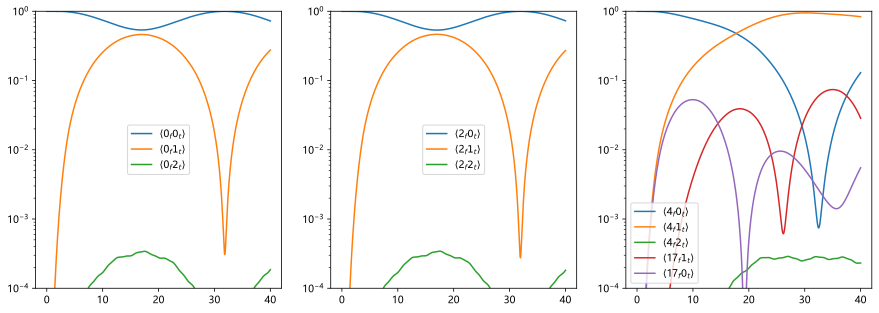

In [20]:

results  = system.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,4]],
    tlist = tlist,
    drive_terms = [DriveTerm( 
                            driven_op= driven_op,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id = 'sdaas',
                            pulse_shape_args={
                                'w_d': system.evals[system.product_to_dressed[(4,1)]] - system.evals[system.product_to_dressed[(4,0)]] ,
                                'amp': amp,
                                't_rise':4,
                                't_square': 1000
                            })],
    # c_ops = c_ops,
    e_ops =  e_ops
)

fig, axes = plt.subplots(1,3,figsize = (15,5))
for i, (result,ql) in enumerate(zip(results,[0,2,4])):
    axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
    axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
    axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
    if ql == 4:
        axes[i].plot(tlist,result.expect[17*max_tl+1],label= rf"$\langle$17$_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[17*max_tl+0],label= rf"$\langle$17$_f0_t\rangle$")
    axes[i].legend()
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4,1)
    # axes[i].set_xlim(0,102)
plt.show()

# second, sin^2 DRAG

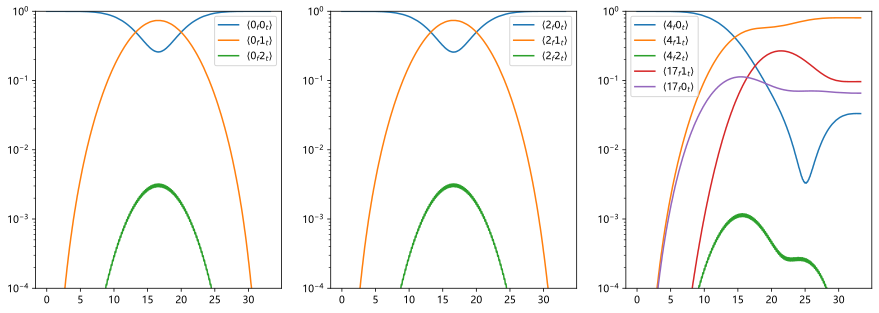

x = [33.2597922, 0.0445467048, -0.000110932413], obj  = -0.9999681375865335


-0.9999681375865335

In [23]:
from scipy.optimize import minimize

def objective(x):
    
    t_duration = x[0]
    amp = x[1]
    amp_correction = x[2]
    tlist = np.linspace(0,t_duration,1000)

    results  = system.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,4]],
        tlist = tlist,
        drive_terms = [DriveTerm( 
                                driven_op= driven_op,
                                pulse_shape_func=sin_squared_DRAG_with_modulation,
                                pulse_id = 'sin2drag',
                                pulse_shape_args={
                                    'w_d': system.evals[system.product_to_dressed[(4,1)]] - system.evals[system.product_to_dressed[(4,0)]] ,
                                    'amp': amp,
                                    'amp_correction':amp_correction,
                                    't_duration': t_duration
                                })],
        # c_ops = c_ops,
        e_ops =  e_ops+[qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(0,0)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(1,0)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(4,1)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(17,1)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(17,0)]))
                  ]
    )
    clear_output()
    fig, axes = plt.subplots(1,3,figsize = (15,5))
    for i, (result,ql) in enumerate(zip(results,[0,2,4])):
        axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
        if ql == 4:
            axes[i].plot(tlist,result.expect[17*max_tl+1],label= rf"$\langle$17$_f1_t\rangle$")
            axes[i].plot(tlist,result.expect[17*max_tl+0],label= rf"$\langle$17$_f0_t\rangle$")
        axes[i].legend()
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-4,1)
        # axes[i].set_xlim(0,102)
    plt.show()
    obj =  -results[0].expect[-5][-1]-results[1].expect[-4][-1] - results[1].expect[-3][-1] - results[1].expect[-2][-1] + results[1].expect[-1][-1]
    print(f"x = {x}, obj  = {obj}")
    return obj



initial_guess = [ 3.32597922e+01 , 4.45467048e-02 , -1.10932413e-04]

# result = minimize(objective, initial_guess, method='Nelder-Mead')

objective(initial_guess)


# third, Gaussian DRAG

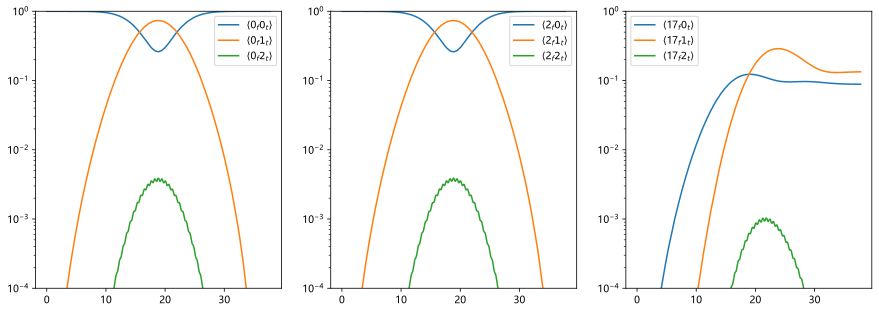

In [26]:
from scipy.optimize import minimize

def objective(x):
    
    t_duration = x[0]
    amp = x[1]
    amp_correction_scaling_factor = x[2]
    tlist = np.linspace(0,t_duration,1000)

    results  = system.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,4]],
        tlist = tlist,
        drive_terms = [DriveTerm( 
                                driven_op= driven_op,
                                pulse_shape_func=gaussian_DRAG_pulse,
                                pulse_id = 'gaussianDRAG',
                                pulse_shape_args={
                                    'w_d': system.evals[system.product_to_dressed[(4,1)]] - system.evals[system.product_to_dressed[(4,0)]] ,
                                    'amp': amp,
                                    'amp_correction_scaling_factor':amp_correction_scaling_factor,
                                    't_duration': t_duration,
                                    'normalize':True
                                })],
        # c_ops = c_ops,
        e_ops =  e_ops+[qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(0,0)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(1,0)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(4,1)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(17,1)])),
                  qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(17,0)]))
                  ]
    )
    clear_output()
    fig, axes = plt.subplots(1,3,figsize = (15,5))
    for i, (result,ql) in enumerate(zip(results,[0,2,4])):
        axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
        if ql == 4:
            axes[i].plot(tlist,result.expect[17*max_tl+1],label= rf"$\langle$17$_f1_t\rangle$")
            axes[i].plot(tlist,result.expect[17*max_tl+0],label= rf"$\langle$17$_f0_t\rangle$")
        axes[i].legend()
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-4,1)
        # axes[i].set_xlim(0,102)
    plt.show()
    obj =  -results[0].expect[-5][-1]-results[1].expect[-4][-1] - results[1].expect[-3][-1] - results[1].expect[-2][-1] + results[1].expect[-1][-1]
    print(f"x = {x}, obj  = {obj}")
    return obj


initial_guess =x = [ 3.77793739e+01 , 4.97582748e-02 ,-9.19069391e-05]


# result = minimize(objective, initial_guess, method='Nelder-Mead')

objective(initial_guess)

# can we detect 17 ?

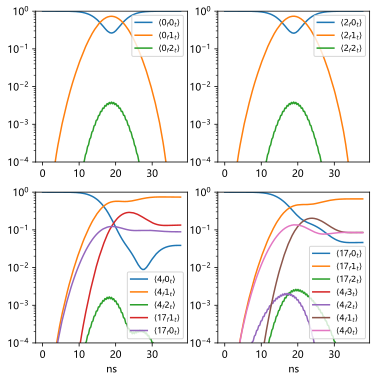

In [5]:
x = [ 3.77793739e+01 , 4.97582748e-02 ,-9.19069391e-05]
t_duration = x[0]
amp = x[1]
amp_correction_scaling_factor = x[2]
tlist = np.linspace(0,t_duration,1000)

results  = system.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,4,17]],
    tlist = tlist,
    drive_terms = [DriveTerm( 
                            driven_op= driven_op,
                            pulse_shape_func=gaussian_DRAG_pulse,
                            pulse_id = 'gaussianDRAG',
                            pulse_shape_args={
                                'w_d': system.evals[system.product_to_dressed[(4,1)]] - system.evals[system.product_to_dressed[(4,0)]] ,
                                'amp': amp,
                                'amp_correction_scaling_factor':amp_correction_scaling_factor,
                                't_duration': t_duration,
                                'normalize':True
                            })],
    # c_ops = c_ops,
    e_ops =  e_ops
)
clear_output()
fig, axes_2d = plt.subplots(2,2,figsize = (6,6))
axes = [axes_2d[0,0],axes_2d[0,1],axes_2d[1,0],axes_2d[1,1]]
for i, (result,ql) in enumerate(zip(results,[0,2,4,17])):
    axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
    axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
    axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
    if ql == 4:
        axes[i].plot(tlist,result.expect[17*max_tl+1],label= rf"$\langle$17$_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[17*max_tl+0],label= rf"$\langle$17$_f0_t\rangle$")
    if ql == 17:
        axes[i].plot(tlist,result.expect[4*max_tl+3],label= rf"$\langle4_f3_t\rangle$")
        axes[i].plot(tlist,result.expect[4*max_tl+2],label= rf"$\langle4_f2_t\rangle$")
        axes[i].plot(tlist,result.expect[4*max_tl+1],label= rf"$\langle4_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[4*max_tl+0],label= rf"$\langle4_f0_t\rangle$")
    axes[i].legend(fontsize = 'small')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4,1)

for i in [2,3]:
    axes[i].set_xlabel(f"ns")
plt.show()
fig.savefig('detect4.pdf')

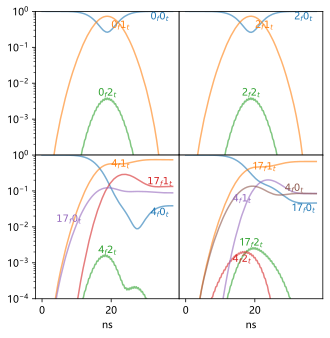

In [41]:
fig = plt.figure(figsize=(5, 5)) 
bottom = 0.15
left = 0.15
l = 0.4

gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom+l,top = bottom+l*2)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom+l,top = bottom+l*2)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom,top = bottom+l)
gs3 = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom,top = bottom+l)

axes = [fig.add_subplot(gs0[0]),
        fig.add_subplot(gs1[0]),
        fig.add_subplot(gs2[0]),
        fig.add_subplot(gs3[0])]

alpha=0.6
for i, (result,ql) in enumerate(zip(results,[0,2,4,17])):
    line, =axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$",alpha=alpha)
    axes[i].text(tlist[-100],result.expect[ql*max_tl+0][-100],s= rf"{ql}$_f0_t$",va='top',ha='center',color=line.get_color())

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$",alpha=alpha)
    axes[i].text(tlist[-400],result.expect[ql*max_tl+1][-400],s= rf"{ql}$_f1_t$",va='center',ha='center',color=line.get_color())

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$",alpha=alpha)
    axes[i].text(tlist[-500],result.expect[ql*max_tl+2][-500],s= rf"{ql}$_f2_t$",va='bottom',ha='center',color=line.get_color())

    if ql == 4:
        line, =axes[i].plot(tlist,result.expect[17*max_tl+1],label= rf"$\langle$17$_f1_t\rangle$",alpha=alpha)
        axes[i].text(tlist[-100],result.expect[17*max_tl+1][-100],s= rf"$17_f1_t$",va='bottom',ha='center',color=line.get_color())

        line, =axes[i].plot(tlist,result.expect[17*max_tl+0],label= rf"$\langle$17$_f0_t\rangle$",alpha=alpha)
        axes[i].text(tlist[-700],result.expect[17*max_tl+0][-700],s= rf"$17_f0_t$",va='top',ha='right',color=line.get_color())
    if ql == 17:
        # line, =axes[i].plot(tlist,result.expect[4*max_tl+3],label= rf"$\langle4_f3_t\rangle$",alpha=alpha)
        # axes[i].text(tlist[-500],result.expect[4*max_tl+3][-500],s= rf"$4_f3_t$",va='top',ha='right',color=line.get_color())

        line, =axes[i].plot(tlist,result.expect[4*max_tl+2],label= rf"$\langle4_f2_t\rangle$",alpha=alpha)
        axes[i].text(tlist[-500],result.expect[4*max_tl+2][-500],s= rf"$4_f2_t$",va='top',ha='right',color=line.get_color())

        line, =axes[i].plot(tlist,result.expect[4*max_tl+1],label= rf"$\langle4_f1_t\rangle$",alpha=alpha)
        axes[i].text(tlist[-500],result.expect[4*max_tl+1][-500],s= rf"$4_f1_t$",va='top',ha='right',color=line.get_color())

        line, =axes[i].plot(tlist,result.expect[4*max_tl+0],label= rf"$\langle4_f0_t\rangle$",alpha=alpha)
        axes[i].text(tlist[-100],result.expect[4*max_tl+0][-100],s= rf"$4_f0_t$",va='bottom',ha='right',color=line.get_color())
    # axes[i].legend(fontsize = 'small')

    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4,1)

for i in [2,3]:
    axes[i].set_xlabel(f"ns")

for i in [1,3]:
    axes[i].yaxis.set_visible(False)

axes[0].set_yticks(axes[0].get_yticks()[2:],
                   axes[0].get_yticklabels()[2:])
axes[0].set_ylim(1e-4,1)
# axes[2].set_yticks(axes[2].get_yticks()[:-2],axes[2].get_yticklabels()[:-2])

plt.show()
fig.savefig('detect4.pdf')